In [12]:
from morfessor import BaselineModel, MorfessorIO
from gensim.models import Word2Vec

In [13]:
io_handler = MorfessorIO()
model = io_handler.read_binary_model_file('../morfessor/morf_isc_model.bin')

In [14]:
def segment_words(model, words):
    segmented_words = []
    for word in words:
        try:
            # Try to segment the word using the model analyses
            segments = model.segment(word)
        except KeyError:
            # If the word is not in the training data, use viterbi_segment
            segments = model.viterbi_segment(word)[0]
        segmented_words.extend(segments)  
    return segmented_words

In [15]:
with open('../data/isc_sentences.txt', 'r') as f:
    sentences = f.readlines()

In [ ]:
sentences_segmented = [segment_words(model, sentence.split()) for sentence in sentences]

# Train Word2Vec model on segmented sentences
w2v_segmented = Word2Vec(sentences_segmented, vector_size=100, window=5, min_count=1, workers=4)

In [6]:
w2v_segmented.save("iscmorf2vec.model")

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings_2D(words, vectors, dimension='tsne'):
    """Visualize word vectors in 2D using t-SNE or PCA."""
    # Reduce dimensionality using t-SNE
    if dimension == 'tsne':
        perplexity = min(30, len(words) - 1)  # Ensure perplexity is less than the number of samples
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
        reduced_vectors = tsne.fit_transform(vectors)
    # Reduce dimensionality using PCA
    # elif dimension == 'pca':
    #     pca = PCA(n_components=2)
    #     reduced_vectors = pca.fit_transform(vectors)
    else:
        raise ValueError("Invalid dimension specified. Use 'tsne' or 'pca'.")

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

    # Annotate each point with the corresponding word
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

    plt.title(f'Visualización 2D de los vectores - Morfessor y word2vec ({dimension.upper()})')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid()
    plt.show()

In [17]:
# read word list from file
with open('../morfessor/isc_words_lower.txt', 'r') as f:
    words = f.readlines()

In [18]:
# segment the words using BPE
words_morf = [segment_words(model, word.split()) for word in words]
# obtain the vectors for each subword and average them to get the vector for the word
vectors = []
for word in words_morf:
    vectors.append(np.mean([w2v_segmented.wv[subword] for subword in word], axis=0))

In [8]:
import random
word_list = list(w2v_segmented.wv.key_to_index.keys())

In [ ]:
# # Sample 20 words from the list
# sampled_words = random.sample(word_list, 20)
# # Get the word vectors for the sampled words
# word_vectors = np.array([w2v_segmented.wv[word] for word in sampled_words])

In [19]:
# get 20 random words vectors
np.random.seed(0)
random_indices = np.random.choice(len(words), 20, replace=False)
random_words = [words[i] for i in random_indices]
random_vectors = [vectors[i] for i in random_indices]
random_vectors = np.array(random_vectors)

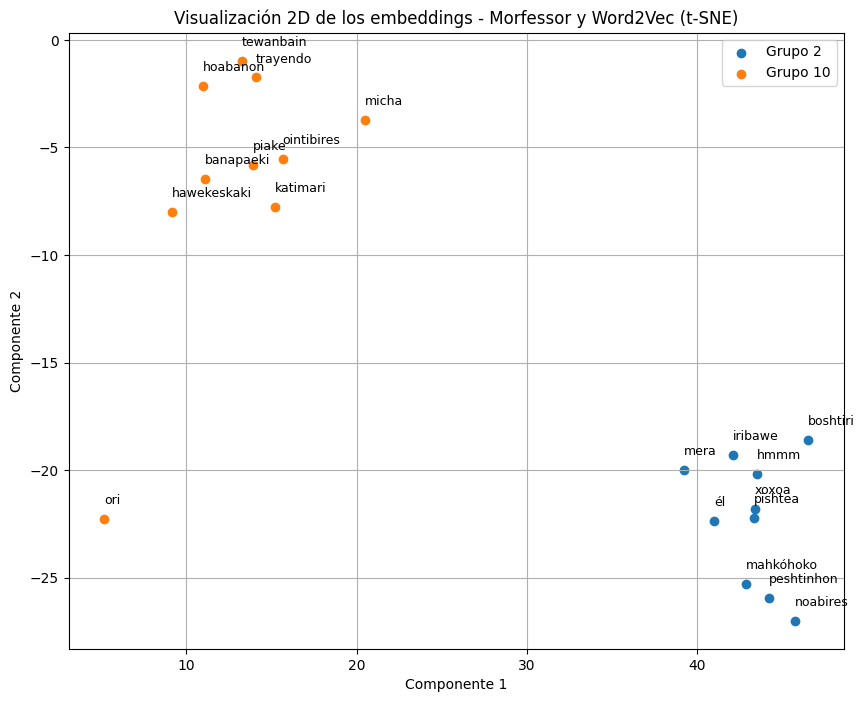

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
# cluster the vectors, plot 2 clusters in 2D with t-SNE, and color the points accordingly, and annotate them with the word
def cluster_embeddings(vectors, words, n_clusters=5, clusters_to_plot=[0, 1], max_words_per_cluster=10):
    """
    Cluster the vectors, plot 2 clusters in 2D with t-SNE, and color the points accordingly, and annotate them with the word.
    Plot a maximum of 10 words per cluster.

    Args:
        vectors (list): List of word vectors.
        words (list): List of words corresponding to the vectors.
        n_clusters (int): Number of clusters to identify.
        clusters_to_plot (list): List of cluster indices to plot.
        max_words_per_cluster (int): Maximum number of words to plot per cluster.
    """
    # Convert vectors to a NumPy array
    vectors = np.array(vectors)
    
    # Cluster the vectors using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
    clusters = kmeans.labels_
    
    # Reduce dimensionality using t-SNE
    perplexity = min(30, len(words) - 1)  # Ensure perplexity is less than the number of samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_vectors = tsne.fit_transform(vectors)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    for cluster in clusters_to_plot:
        indices = [i for i, c in enumerate(clusters) if c == cluster]
        # Limit the number of words plotted per cluster
        indices = indices[:max_words_per_cluster]
        plt.scatter(reduced_vectors[indices, 0], reduced_vectors[indices, 1], label=f'Grupo {cluster}')
        for i in indices:
            plt.annotate(words[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)
    
    plt.title('Visualización 2D de los embeddings - Morfessor y Word2Vec (t-SNE)')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend()
    plt.grid()
    plt.show()

cluster_embeddings(np.array(vectors), words, n_clusters=100, clusters_to_plot=[2, 10])

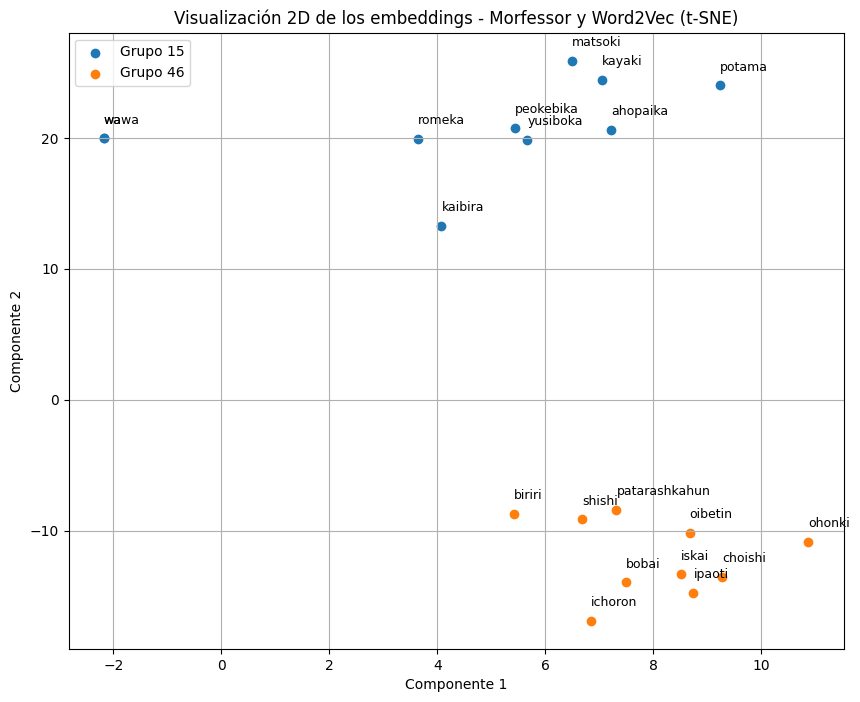

In [62]:
cluster_embeddings(np.array(vectors), words, n_clusters=100, clusters_to_plot=[15, 46])

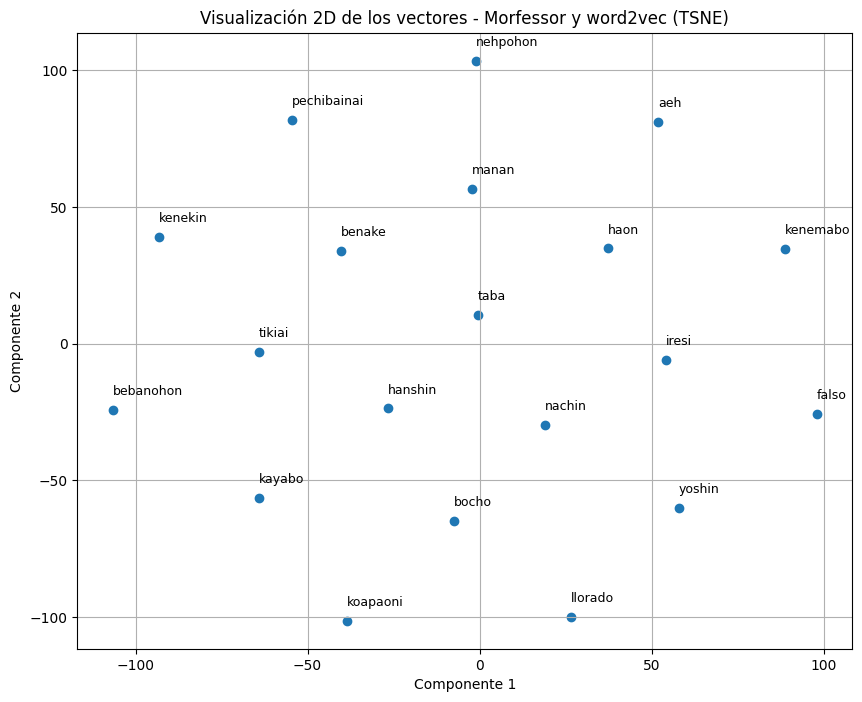

In [20]:
visualize_embeddings_2D(random_words,random_vectors)